# Linear Models for Predicting Continuous Values

## Linear Structure

$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

In [6]:
import numpy as np # we will need this later!

Given $N$ observations, $\xv_n$, for $n=1,\ldots,N$, and target values,
$t_n$, for $n=1,\ldots,N$, what is the simplest model,
$g(\xv)$, you can think of?

$$
g(\xv) = 0
$$

or maybe

$$
g(\xv) = c
$$

What is next simplest model?

$$
\begin{align*}
   g(\xv;\wv) &= w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D \\
   &= w_0 + \sum_{i=1}^D w_i x_i \\
   & = \sum_{i=0}^D w_i x_i \mbox{, where } x_0 = 1 \\
   &= \wv^T \xv
\end{align*}
$$

In [7]:
# wait, what's that T for?
# w0x0 + w1x1 + w2x2 + w3x3
w = np.array([0,1,2,3])
x = np.array([1,2,3,0])
print("%s\n*\n%s\n=\n%s" % (w,x,w * x))

[0 1 2 3]
*
[1 2 3 0]
=
[0 2 6 0]


In [8]:
# all that does is multiply elementwise :(
# g(x;w) should give us a single number
# how do we get a single number out of this?

# remember the matmul operator? @

w @ x

8

In [9]:
(w[0]*x[0])+(w[1]*x[1])+(w[2]*x[2])+(w[3]*x[3])

8

OK, cool, but you still haven't explained that $^T$!

In [10]:
# try it again with 2x4 matrices
w = np.array([[0,1,2,3],[3,2,1,0]])
x = np.array([[1,2,3,0],[1,2,3,0]])
print(w.shape,x.shape)
print("%s\n*\n%s\n=\n%s" % (w,x,w * x))
print(w @ x)

(2, 4) (2, 4)
[[0 1 2 3]
 [3 2 1 0]]
*
[[1 2 3 0]
 [1 2 3 0]]
=
[[0 2 6 0]
 [3 4 3 0]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 4)

In [11]:
print(np.transpose(w), "\n", x)
print(np.shape(np.transpose(w)), np.shape(w))

[[0 3]
 [1 2]
 [2 1]
 [3 0]] 
 [[1 2 3 0]
 [1 2 3 0]]
(4, 2) (2, 4)


In [12]:
np.transpose(w) @ x

array([[3, 6, 9, 0],
       [3, 6, 9, 0],
       [3, 6, 9, 0],
       [3, 6, 9, 0]])

An $n \times k$ matrix $\times$ a $k \times m$ matrix will equal an $n \times m$ matrix.

If $n = 1$, $\wv^T = \wv$

In [13]:
np.transpose([0,1,2,3])

array([0, 1, 2, 3])

  * $\wv^T\xv$ is nice because it is linear in the parameters $\wv$; optimizations based on derivatives might be solvable analytically.
  * $\wv^T\xv$ is not so nice, because it is also linear in the inputs, $\xv$; greatly limits the complexity of the model. Most famously, linear models cannot solve the XOR :(
  * But, a model linear in the inputs might be the best you can do for many cases, such as a sparsely sampled distribution, process, population, thing...whatever it is you want to model.

## Fitting Data Samples with a Linear Model

* Force $F$ exerted by a spring is proportional to its length $y$ (Hooke's Law: $y = kF$).
* The potential energy stored in a spring is proportional to the *square* of its length.

![title]("Images/spring.png")

Say we want the rod to settle at a position that **minimizes the potential
energy in a set of springs** (e.g., see image above). We conduct a series of $n$ measurements of potential energy with differnt rod positions that stretch/compress the different springs.  Spring lengths are stored as a vector $\wv$ .

$$
\begin{align*}
\sum_{n=1}^N (t_n - g(\xv_n;\wv))^2
\end{align*}
$$

$t_n$ represents the $n$-th experimental measurement (potential energy stored in the springs).

If $g$ is an **affine** (linear + constant) function of $\xv$ (the lengths of the springs),
$$
    g(\xv;\wv) = w_0 + w_1 x_1 + ... + w_D x_D
$$
with parameters $\wv = (w_0, w_1, ..., w_D)$.

Which parameter values give best fit?
$$
    \wv_{\mbox{best}} = \argmin{\wv} \sum_{n=1}^N (t_n - g(\xv_n ; \wv))^2
$$

Set derivative (gradient) with respect to $\wv$ to zero and
solve for $\wv$.  Let's do this with matrices. 

The matrix formulas are a bit simpler if we assume that $w_0$ is multipled by the constant 1, and that $x_{i, 0}$, the first component of sample $i$, is the constant 1.

Collect all targets (observations you want to fit to) into matrix $T$ and $x$ samples into matrix
$X$. ($N$=number samples, i.e., number of observations you made, $D$=sample dimensionality, e.g., number of springs)
$$
  \begin{align*}
    T &= \begin{bmatrix}
      t_1 \\ t_2 \\ \vdots \\ t_N
    \end{bmatrix} \\
    X &= \begin{bmatrix}
      x_{1,0} & x_{1,1} & x_{1,2} & \dotsc & x_{1,D} \\
      x_{2,0} & x_{2,1} & x_{2,2} & \dotsc & x_{2,D} \\
      \vdots \\
      x_{N,0} & x_{N,1} & x_{N,2} & \dotsc & x_{N,D}
    \end{bmatrix}\\
    \wv &= \begin{bmatrix} w_0 \\ w_1 \\ \vdots \\ w_D \end{bmatrix}
  \end{align*}
$$

In [14]:
N = 3 # N = num. observations (e.g., number of measurements)
D = 4 # D = num. variable values per observations (e.g., number of springs)
T = np.array(np.random.rand(N))
X = np.array(np.random.rand(N,D))
w = np.array(np.random.rand(D))
T,X,w

(array([0.85777025, 0.99707882, 0.12914277]),
 array([[0.41484988, 0.1783967 , 0.86339619, 0.59753154],
        [0.30888746, 0.27004817, 0.37939537, 0.74979592],
        [0.10462448, 0.33988299, 0.23357028, 0.03054998]]),
 array([0.1546631 , 0.65724048, 0.35615155, 0.82696145]))

Collection of all differences is $T - X\wv$, which is an $N \times
1$ matrix.  To form the square of all values and add them up, just
do a dot product $(T-X\wv)^T (T-X\wv)$.  This only works if the value we are predicting is a scalar, which means $T$ is a column matrix.  If we want to predict more than one value for each sample, $T$ will have more than one column.  Let's continue with the derivation assuming $T$ has $K$ columns, meaning we want a linear model with $K$ outputs.

In [15]:
T-X@w

array([-0.1252767 ,  0.01664416, -0.2188737 ])

In [16]:
np.transpose(T-X@w)@(T-X@w)

0.0638769767729828

In [17]:
(T-X@w).T@(T-X@w) # .T is the same as np.transpose

0.0638769767729828

To find the best value for $\wv$, we take the derivative of the sum of squared error objective, set it equal to 0 and solve for $\wv$. 

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - g(\xv_n;\wv))^2}{\partial \wv} &= -2 \sum_{n=1}^N (\tv_n - g(\xv_n;\wv) \frac{\partial g(\xv_n;\wv)}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \frac{\partial \xv_n^T \wv}{\partial \wv}\\
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T
\end{align*}
$$

Here's where we get the benefit of expressing the $\xv_n$ and $t_n$ samples as matrices. The sum can be performed with a dot product:

$$
\begin{align*}
\frac{\partial \sum_{n=1}^N (\tv_n - g(\xv_n;\wv))^2}{\partial \wv} 
&= -2 \sum_{n=1}^N (\tv_n - \xv_n^T \wv) \xv_n^T\\
&= -2 \Xv^T (\Tv - \Xv \wv)
\end{align*}
$$

Check the sizes and shapes of each matrix in the last equation above.

In [18]:
X.shape

(3, 4)

In [19]:
X.T.shape

(4, 3)

In [20]:
T.shape

(3,)

In [21]:
w.shape

(4,)

Now we can set this equal to zero and solve for $\wv$.

$$
\begin{align*}
-2 \Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T (\Tv - \Xv \wv) &= 0\\
\Xv^T \Tv &= \Xv^T \Xv \wv\\
\wv &= (\Xv^T \Xv)^{-1} \Xv^T \Tv
\end{align*}
$$

And, in python:

In [22]:
inv_w = np.linalg.inv(X.T @ X)@(X.T @ T)
inv_w

array([4., 0., 1., 0.])

or, you may use the *solve* function that assumes $\Xv^T \Xv$ is full rank (no linearly dependent columns--that is no column can be represented in terms of other columns, e.g., not $k \times$ some other other column, not some other column + $k$, not $n$ other columns added together):

In [23]:
solve_w = np.linalg.solve(X.T @ X, X.T @ T)
solve_w

array([ 2.77705991, -0.02774224, -0.72419976,  0.56219245])

or, better yet, use the *lstsq* function that does not make that assumption.

In [24]:
np.linalg.lstsq(X.T @ X, X.T @ T, rcond=None)

(array([0.28454202, 0.16442637, 0.03783319, 1.13421606]),
 array([], dtype=float64),
 3,
 array([2.14801319e+00, 1.26385694e-01, 8.84512103e-02, 2.06280955e-17]))

???? OK, hold on!

In [25]:
np.linalg.lstsq?

In [26]:
lstsq_w, residuals, rank, s = np.linalg.lstsq(X.T @ X, X.T @ T, rcond=None)
lstsq_w

array([0.28454202, 0.16442637, 0.03783319, 1.13421606])

But these solutions aren't the same!

In [27]:
np.allclose?

In [28]:
np.allclose(np.dot(X.T @ X, lstsq_w), X.T @ T)

True

In [29]:
np.allclose(np.dot(X.T @ X, solve_w), X.T @ T)

True

In [30]:
np.allclose(np.dot(X.T @ X, solve_w), np.dot(X.T @ X, lstsq_w))

True

There may be multiple solutions to a system of equations.
Many times, $A \cdotp B = A \cdotp C \wedge B \neq C$.

The ```lstsq``` and ```solve``` functions can be written with simpler arguments, like

    w, residuals, rank, s = = np.linalg.lstsq(X, T)
    
because they are designed to find the value of $\wv$ that minimizes the squared error between $X \wv$ and $T$.  Using the matrix products as arguments will simplify our implementation of ridge regression a little bit later in this course.  For now, let's use the simpler version.

In [31]:
w, residuals, rank, s = np.linalg.lstsq(X, T, rcond=None)
w

array([0.28454202, 0.16442637, 0.03783319, 1.13421606])

## Incremental Way

But what if you have thousands or millions of samples?  $X$ and $T$
can be quite large. To avoid dealing with matrix operations on huge
matrices, we can derive a sequential algorithm for finding $\wv$ by
using the fact that a derivative of a sum is the sum of the
derivatives.  We will now express this derivative as a gradient, which is a vector or matrix of derivatives. ($\nabla$ -- pronounced "del" -- represents a gradient).

$$
\begin{align*}
g(\xv_n, \wv) &= w_0 + w_1 x_{n,1} + w_2 x_{n,2} + \cdots + w_D x_{n,D} = \xv_n^T \wv\\
E(\Xv, \Tv, \wv) &= \sum_{n=1}^N (t_n - g(\xv_n, \wv))^2\\
\nabla_\wv E(\Xv, \Tv, \wv) &= \nabla_\wv \left ( \sum_{n=1}^N (t_n - g(\xv_n, \wv))^2 \right )\\
&= 
\sum_{n=1}^N \nabla_\wv (t_n - g(\xv_n, \wv))^2\\
&= 
\sum_{n=1}^N 2 (t_n - g(\xv_n, \wv)) \nabla_\wv (t_n - g(\xv_n, \wv)) \\
&= 
\sum_{n=1}^N 2 (t_n - g(\xv_n, \wv)) (-1) \nabla_\wv g(\xv_n, \wv) \\
&= 
\sum_{n=1}^N 2 (t_n - g(\xv_n, \wv)) (-1) \nabla_\wv (\xv_n^T \wv) \\
&= 
\sum_{n=1}^N 2 (t_n - g(\xv_n, \wv)) (-1) \xv_n \\
&= 
-2 \sum_{n=1}^N (t_n - g(\xv_n, \wv))  \xv_n \\
\end{align*}
$$

Instead of summing over all $N$ samples, what if we
just update $\wv$ after each sample based on the gradient of $E$ for that sample?  The gradient for a 
sample $n$ can be
considered as a limited, or noisy, sample of the true gradient.
Thus, we can take a small step in the direction of the negative gradient to try
to bring a current guess at the weight vector, $\wv^{(k)}$, on
iteration $k$ to a new value, $\wv^{(k+1)}$, on iteration $k+1$ that is closer to a value that reduces the overall error. This kind of update is called "stochastic approximation".

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)} - (-2) \rho (t_n - g(\xv_n, \wv)) \xv_n\\
 &= \wv^{(k)} + \rho (t_n - g(\xv_n, \wv)) \xv_n
\end{align*}
$$

For this sequential algorithm to converge, $\rho$ must decrease with
each iteration, not too fast but not too slow. 

This algorithm is called the least mean squares (LMS) algorithm
developed by Widrow and Hoff.  It is now often referred to as the
**''stochastic gradient descent'' algorithm, or SGD.**

If we have two output variables, like mpg and horsepower, then $t_n$ is no longer a scalar.  How do we deal with that?  Well, to predict two variables, we need two linear models.  We can do this by changing $\wv$ from a single column matrix to a two-column matrix.  The first column could contain the weights used to predict mpg, and the second column could contain weights to predict horsepower.  Now our linear model is

$$ g(\xv_n, \wv) = \xv_n^T \wv$$

Humm, no change here!  This is the beauty of using matrix math.  The input vector $\xv_n$ is dotted with each of the two columns of $\wv$, resulting in two values, or a two-component resulting vector, giving the predictions for mpg and horsepower.

What changes do we need to make to the SGD update formula?  What else must we modify, other than $\wv$?  For each sample, $n$, we must specify two target values, for mpg and horsepower.  So $t_n$ is no longer a scalar, but now has two values in a vector, or $\tv_n$.  To update the weights $\wv$ we must multiply each error by each input component. This does sound like a double loop.  Well, in the last equation above we already used matrix math and ```numpy``` broadcasting once in

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)}  + \rho \; (t_n - g(\xv_n, \wv)) \; \xv_n
\end{align*}
$$

to remove the loop over all of the components in $\wv_n$ and $\xv_n$.  Now we will use broadcasting again to remove a loop over target components, in $\tv_n$.  We must take care to make sure the matrices are of the right shape in the matrix operations, and that the resulting matrix is the correct shape for $\wv$.  Here we follow the convention that vectors are column vectors.

$$
\begin{align*}
\wv^{(k+1)} &= \wv^{(k)}  + \rho \; \xv_n \; (\tv_n^T - g(\xv_n, \wv))) 
\end{align*}
$$

Let's see, $\rho$ is a scalar, $\xv_n$ is $D+1\times 1$, a column vector with $D+1$ components (counting the constant 1), $\tv_n$ is $K\times 1$ if we have $K$ outputs,
so $\tv_n^T$ is $1\times K$  and $g(\xv_n, \wv) = \xv_n^T \wv$ is also $1\times K$.  Stringing these dimensions together in the  calculation gives us $(D+1\times 1) (1\times K)$ which results in $D+1\times K$ exactly the correct shape for our weight matrix $\wv$!

In Python, the update to the weight matrix for the $n^{th}$ sample is just

     w += rho * X1[n:n+1, :].T * (T[n:n+1, :] - predicted)
     
The long, boring, non-matrix way to update each element of `w` would look like

     nOutputs = T.shape[1]
     nInputs = X1.shape[1]
     for k in range(nOutputs):
         for i in range(nInputs):
             w[i,k] += rho * X1[n:n+1, i] * (T[n:n+1, k] - predicted[k])

So many lines of code can lead to more bugs!!

## Example of SGD in Action

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output  # for the following animation

Let's make some silly data to play with.  Make 100 samples of random $x$ values between 0 and 10, and assign the target for each sample to be $2 - .1 X + .05(X - 6)^2 + \epsilon$, where $\epsilon$ is a bit of noise as a random value from a Normal distribution with mean 0 and standard deviation 0.1.

In [145]:
n_samples = 100
X = np.random.uniform(0, 10, (n_samples, 1))
T = 2 - .1 * X + .05 * (X - 6)**2 + np.random.normal(0, 0.1, (n_samples,1))

In [146]:
# np.random.normal samples from a normal (Gaussian) distribution
# default mean of 0, default std. dev. of 1 (we make this 0.1 above)
np.random.normal?

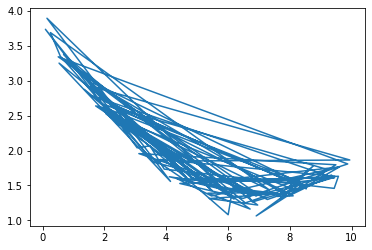

In [147]:
plt.plot(X, T)

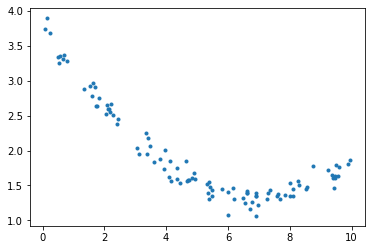

In [148]:
# plot as points
plt.plot(X, T, '.')

Do you think we can fit a linear model to this data?

First, let's modify the $X$ input matrix to include an initial column of constant 1.

In [149]:
X1 = np.insert(X, 0, 1, axis=1)

# remember, data always consists of your input values (the "sample", X, or X1 with bias) and your output values (the "target", T)
X1.shape, T.shape

((100, 2), (100, 1))

In [150]:
learning_rate = 0.001
n_samples = X1.shape[0]
n_samples   # number of rows in data equals the number of samples

100

In [151]:
w = np.zeros((2, 1))                # initialize the weights to zeros
for epoch in range(1000):             # train for this many epochs, or passes through the data set
    for n in range(n_samples):
        y = X1[n:n + 1, :] @ w      # predicted value, y, for sample n -> we get this by multiplying the sample by weights
        error = T[n:n + 1, :] - y   # the error is  the difference between predicted value and target output (real data)
        # update weights by fraction of negative derivative of square error with respect to weights
        w += learning_rate * X1[n:n + 1, :].T * error  
        
print(w)

[[ 2.92790141]
 [-0.19727423]]


Let's see how well this linear model (defined by these resulting weights) fits the data.  To do so, we can plot the model's predictions on top of the plot of actual data.

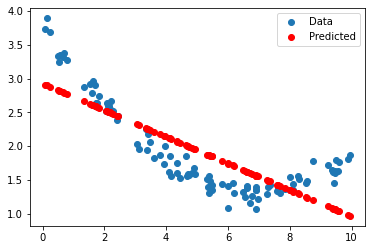

In [152]:
plt.plot(X, T, 'o', label='Data')
plt.plot(X, X1 @ w, 'ro', label='Predicted') # X1 @ w <- there's our prediction again this time all done at once with a matrix
plt.legend();

Let's animate each step by drawing the predictions made by the linear model as weights are updated.

In [153]:
def run(rho, n_epochs, stepsPerFrame=10):

    # Initialize weights to all zeros
    # For this demonstration, we will have one variable input. With the constant 1 input, we have 2 weights.
    w = np.zeros((2,1))

    # Collect the weights after each update in a list for later plotting. 
    # This is not part of the training algorithm
    ws = [w.copy()]

    # Create a bunch of x values for plotting
    xs = np.linspace(0, 10, 100).reshape((-1,1))
    # Insert constant column of 1s
    xs1 = np.insert(xs, 0, 1, axis=1)

    fig = plt.figure(figsize=(8, 8))

    # For each pass (one epoch) through all samples ...
    for iter in range(n_epochs):
        # For each sample ...
        for n in range(n_samples):
        
            # Calculate prediction using current model, w.
            #    n:n+1 is used instead of n to preserve the 2-dimensional matrix structure
            predicted = X1[n:n+1,:] @ w
            
            # Update w using negative gradient of error for nth sample
            w += rho * X1[n:n+1, :].T * (T[n:n+1, :] - predicted)
            
            # Add new w to our list of past w values for plotting
            ws.append(w.copy())
        
            if n % stepsPerFrame == 0:
                fig.clf()

                # Plot the X and T data.
                plt.subplot(2, 1, 1)
                plt.plot(X, T, 'o', alpha=0.6, label='Data')
                plt.plot(X[n,0], T[n], 'ko', ms=10, label='Last Trained Sample')

                # Plot the output of our linear model for a range of x values
                plt.plot(xs, xs1 @ w, 'r-', linewidth=5, label='Model')
                plt.xlabel('$x$')
                plt.legend(loc='upper right')
                plt.xlim(0, 10)
                plt.ylim(0, 5)

                # In second panel plot the weights versus the epoch number
                plt.subplot(2, 1, 2)
                plt.plot(np.array(ws)[:, :, 0])
                plt.xlabel('Updates')
                plt.xlim(0, n_epochs * n_samples)
                plt.ylim(-1, 3)
                plt.legend(('$w_0$', '$w_1$'))
        
                clear_output(wait=True)
                display(fig)
    
    clear_output(wait=True)
    
    return w

array([[ 2.63167845],
       [-0.12531617]])

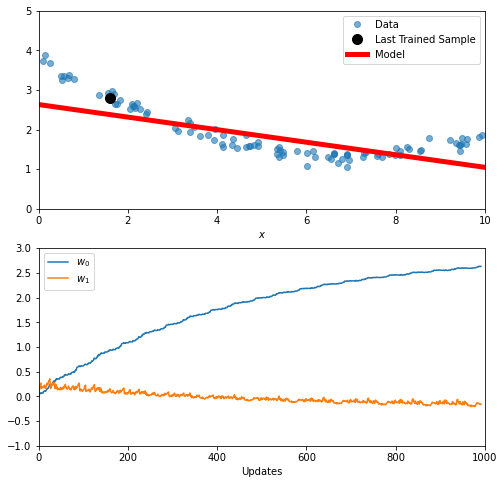

In [154]:
run(0.01, n_epochs=10, stepsPerFrame=10)

## Matrix Multiplication is Solving Systems of Equations

Linear regression (and all ML) prediction **multiplies the input(s) by the weights**.

$\begin{cases} 4x - 3y = 17 \\ x + 4y = 9 \end{cases}$

$x = 9 - 4y$

$4(9 - 4y) - 3y = 17$

$36 - 16y - 3y = 36 - 19y = 17$

$-19y = 17 - 36 = -19$

$y = 1$

$4x - 3(1) = 17$

$4x = 20$

$x = 5$

$(x, y) = (5, 1)$

In [155]:
X = np.array([[4,-3],[1,4]]) # our coefficients
T = np.array([17,9]) # our target values (right-hand side)

$X \cdotp \begin{bmatrix} x \\ y \end{bmatrix} = T$

$\begin{bmatrix} x \\ y \end{bmatrix} = X^{-1}T$

In [156]:
np.linalg.inv(X) @ T

array([5., 1.])

In [157]:
w, residuals, rank, s = np.linalg.lstsq(X,T,rcond=None)
np.linalg.lstsq?
w

array([5., 1.])

In [56]:
residuals
# from docstring: If the rank of `a` is < N or M <= N, this is an empty array.
# `a` is X here, `b` is T, N is `a`'s second dimension, M is the first dimension of `b`

array([], dtype=float64)

In [57]:
print(np.linalg.matrix_rank(X),X.shape,T.shape,np.linalg.matrix_rank(X) < X.shape[1],T.shape[0] <= X.shape[1])

2 (2, 2) (2,) False True


M <= N here, so there are no residuals, but what are residuals?

### Errors vs. Residuals

* **Error**: deviation of the observed value from the (unobservable) *true* value of a quantity
* **Residual**: difference between the observed value and the *estimated* value of the quantity

In these simple linear algebra examples, errors and residuals don't really apply (we get exact values and know our true values, and they're the same).  **However** recall that the prediction step is basically $X^{-1}T$ to solve for $\wv$ and if $T$ contains inexact values, or variables corresponding to $X$ don't linearly predict $T$, then the best we can do is approximation.

## Application

Now we can play with some real data.

Try the [automobile data set](http://mlr.cs.umass.edu/ml/datasets/Auto+MPG) at UCI Machine Learning Database 
Repository. Download
*auto-mpg.data* and *auto-mpg.names* from the "Data Folder" link
near the top of the web page.

In [158]:
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original
!curl -O https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 32149  100 32149    0     0  32149      0  0:00:01 --:--:--  0:00:01 52703
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1660  100  1660    0     0   1660      0  0:00:01 --:--:--  0:00:01  7094


First, take a look at *auto-mpg.names*.  There you will learn that there are 398 samples, each with 8 numerical attributes and one string attribute. Their names are

   1. mpg:           continuous
   2. cylinders:     multi-valued discrete
   3. displacement:  continuous
   4. horsepower:    continuous
   5. weight:        continuous
   6. acceleration:  continuous
   7. model year:    multi-valued discrete
   8. origin:        multi-valued discrete
   9. car name:      string (unique for each instance)

First step, read it into python and look at it.

In [159]:
import pandas  # to help with reading csv file with missing values

Take a look at a few lines of the data file to figure out how to read it in.

In [160]:
# use this on *nix systems
!head -40 auto-mpg.data-original

'head' is not recognized as an internal or external command,
operable program or batch file.


In [161]:
# use this on Windows
!more auto-mpg.data-original +0

18.0   8.   307.0      130.0      3504.      12.0   70.  1.     "chevrolet chevelle malibu"
15.0   8.   350.0      165.0      3693.      11.5   70.  1.     "buick skylark 320"
18.0   8.   318.0      150.0      3436.      11.0   70.  1.     "plymouth satellite"
16.0   8.   304.0      150.0      3433.      12.0   70.  1.     "amc rebel sst"
17.0   8.   302.0      140.0      3449.      10.5   70.  1.     "ford torino"
15.0   8.   429.0      198.0      4341.      10.0   70.  1.     "ford galaxie 500"
14.0   8.   454.0      220.0      4354.       9.0   70.  1.     "chevrolet impala"
14.0   8.   440.0      215.0      4312.       8.5   70.  1.     "plymouth fury iii"
14.0   8.   455.0      225.0      4425.      10.0   70.  1.     "pontiac catalina"
15.0   8.   390.0      190.0      3850.       8.5   70.  1.     "amc ambassador dpl"
NA     4.   133.0      115.0      3090.      17.5   70.  2.     "citroen ds-21 pallas"
NA     8.   350.0      165.0      4142.      11.5   70.  1.     "chevrolet c

35.1   4.   81.00      60.00      1760.      16.1   81.  3.     "honda civic 1300"
32.3   4.   97.00      67.00      2065.      17.8   81.  3.     "subaru"
37.0   4.   85.00      65.00      1975.      19.4   81.  3.     "datsun 210 mpg"
37.7   4.   89.00      62.00      2050.      17.3   81.  3.     "toyota tercel"
34.1   4.   91.00      68.00      1985.      16.0   81.  3.     "mazda glc 4"
34.7   4.   105.0      63.00      2215.      14.9   81.  1.     "plymouth horizon 4"
34.4   4.   98.00      65.00      2045.      16.2   81.  1.     "ford escort 4w"
29.9   4.   98.00      65.00      2380.      20.7   81.  1.     "ford escort 2h"
33.0   4.   105.0      74.00      2190.      14.2   81.  2.     "volkswagen jetta"
34.5   4.   100.0      NA         2320.      15.8   81.  2.     "renault 18i"
33.7   4.   107.0      75.00      2210.      14.4   81.  3.     "honda prelude"
32.4   4.   108.0      75.00      2350.      16.8   81.  3.     "toyota corolla"
32.9   4.   119.0      100.0      26

In [162]:
df = pandas.read_csv('auto-mpg.data-original')
df

,"18.0 8. 307.0 130.0 3504. 12.0 70. 1.\t""chevrolet chevelle malibu"""
0,15.0 8. 350.0 165.0 3693. 1...
1,18.0 8. 318.0 150.0 3436. 1...
2,16.0 8. 304.0 150.0 3433. 1...
3,17.0 8. 302.0 140.0 3449. 1...
4,15.0 8. 429.0 198.0 4341. 1...
...,...
400,27.0 4. 140.0 86.00 2790. 1...
401,44.0 4. 97.00 52.00 2130. 2...
402,32.0 4. 135.0 84.00 2295. 1...
403,28.0 4. 120.0 79.00 2625. 1...


Also, nastily formatted (check that first row, especially).

In [163]:
pandas.read_csv?

Also read through [this pandas.read_csv tutorial](https://honingds.com/blog/pandas-read_csv/).

In [164]:
df = pandas.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True)
df

,0,1,2,3,4,5,6,7,8
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


In [165]:
df.iloc[30:40] # look at rows 30-39

,0,1,2,3,4,5,6,7,8
30,21.0,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin
31,10.0,8.0,360.0,215.0,4615.0,14.0,70.0,1.0,ford f250
32,10.0,8.0,307.0,200.0,4376.0,15.0,70.0,1.0,chevy c20
33,11.0,8.0,318.0,210.0,4382.0,13.5,70.0,1.0,dodge d200
34,9.0,8.0,304.0,193.0,4732.0,18.5,70.0,1.0,hi 1200d
35,27.0,4.0,97.0,88.0,2130.0,14.5,71.0,3.0,datsun pl510
36,28.0,4.0,140.0,90.0,2264.0,15.5,71.0,1.0,chevrolet vega 2300
37,25.0,4.0,113.0,95.0,2228.0,14.0,71.0,3.0,toyota corona
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117


In [166]:
# thre are some NaNs there, that will mess things up, so let's get rid of them
df = pandas.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, na_values='?')
df

,0,1,2,3,4,5,6,7,8
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


In [167]:
df.iloc[30:40]

,0,1,2,3,4,5,6,7,8
30,21.0,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin
31,10.0,8.0,360.0,215.0,4615.0,14.0,70.0,1.0,ford f250
32,10.0,8.0,307.0,200.0,4376.0,15.0,70.0,1.0,chevy c20
33,11.0,8.0,318.0,210.0,4382.0,13.5,70.0,1.0,dodge d200
34,9.0,8.0,304.0,193.0,4732.0,18.5,70.0,1.0,hi 1200d
35,27.0,4.0,97.0,88.0,2130.0,14.5,71.0,3.0,datsun pl510
36,28.0,4.0,140.0,90.0,2264.0,15.5,71.0,1.0,chevrolet vega 2300
37,25.0,4.0,113.0,95.0,2228.0,14.0,71.0,3.0,toyota corona
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117


In [168]:
df.dropna()

,0,1,2,3,4,5,6,7,8
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


In [169]:
df.iloc[30:40]

,0,1,2,3,4,5,6,7,8
30,21.0,6.0,199.0,90.0,2648.0,15.0,70.0,1.0,amc gremlin
31,10.0,8.0,360.0,215.0,4615.0,14.0,70.0,1.0,ford f250
32,10.0,8.0,307.0,200.0,4376.0,15.0,70.0,1.0,chevy c20
33,11.0,8.0,318.0,210.0,4382.0,13.5,70.0,1.0,dodge d200
34,9.0,8.0,304.0,193.0,4732.0,18.5,70.0,1.0,hi 1200d
35,27.0,4.0,97.0,88.0,2130.0,14.5,71.0,3.0,datsun pl510
36,28.0,4.0,140.0,90.0,2264.0,15.5,71.0,1.0,chevrolet vega 2300
37,25.0,4.0,113.0,95.0,2228.0,14.0,71.0,3.0,toyota corona
38,25.0,4.0,98.0,NaN,2046.0,19.0,71.0,1.0,ford pinto
39,NaN,4.0,97.0,48.0,1978.0,20.0,71.0,2.0,volkswagen super beetle 117


In [170]:
df.isna().sum() # detect missing values

0    8
1    0
2    0
3    6
4    0
5    0
6    0
7    0
8    0
dtype: int64

In [171]:
df = df.dropna()
df.iloc[30:40]

,0,1,2,3,4,5,6,7,8
36,28.0,4.0,140.0,90.0,2264.0,15.5,71.0,1.0,chevrolet vega 2300
37,25.0,4.0,113.0,95.0,2228.0,14.0,71.0,3.0,toyota corona
40,19.0,6.0,232.0,100.0,2634.0,13.0,71.0,1.0,amc gremlin
41,16.0,6.0,225.0,105.0,3439.0,15.5,71.0,1.0,plymouth satellite custom
42,17.0,6.0,250.0,100.0,3329.0,15.5,71.0,1.0,chevrolet chevelle malibu
43,19.0,6.0,250.0,88.0,3302.0,15.5,71.0,1.0,ford torino 500
44,18.0,6.0,232.0,100.0,3288.0,15.5,71.0,1.0,amc matador
45,14.0,8.0,350.0,165.0,4209.0,12.0,71.0,1.0,chevrolet impala
46,14.0,8.0,400.0,175.0,4464.0,11.5,71.0,1.0,pontiac catalina brougham
47,14.0,8.0,351.0,153.0,4154.0,13.5,71.0,1.0,ford galaxie 500


In [172]:
df.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

Remember, the next step after reading data into python is to visualize
it.  One thing we can do is just plot the value of each attribute in a
separate graph.  Let's make an array of column names to label the y axes.

In [173]:
df.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

In [174]:
names =  ['mpg','cylinders','displacement','horsepower','weight',
          'acceleration','year','origin', 'model']
names

['mpg',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin',
 'model']

In [175]:
df.columns = names

In [176]:
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,model
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
401,27.0,4.0,140.0,86.0,2790.0,15.6,82.0,1.0,ford mustang gl
402,44.0,4.0,97.0,52.0,2130.0,24.6,82.0,2.0,vw pickup
403,32.0,4.0,135.0,84.0,2295.0,11.6,82.0,1.0,dodge rampage
404,28.0,4.0,120.0,79.0,2625.0,18.6,82.0,1.0,ford ranger


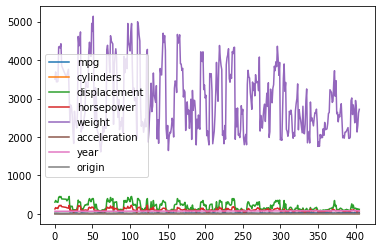

In [177]:
df.plot();

In [178]:
data = df.values
data

array([[18.0, 8.0, 307.0, ..., 70.0, 1.0, 'chevrolet chevelle malibu'],
       [15.0, 8.0, 350.0, ..., 70.0, 1.0, 'buick skylark 320'],
       [18.0, 8.0, 318.0, ..., 70.0, 1.0, 'plymouth satellite'],
       ...,
       [32.0, 4.0, 135.0, ..., 82.0, 1.0, 'dodge rampage'],
       [28.0, 4.0, 120.0, ..., 82.0, 1.0, 'ford ranger'],
       [31.0, 4.0, 119.0, ..., 82.0, 1.0, 'chevy s-10']], dtype=object)

In [179]:
data = df.iloc[:, :-1].values # view everything except the car names (last column)
data

array([[ 18. ,   8. , 307. , ...,  12. ,  70. ,   1. ],
       [ 15. ,   8. , 350. , ...,  11.5,  70. ,   1. ],
       [ 18. ,   8. , 318. , ...,  11. ,  70. ,   1. ],
       ...,
       [ 32. ,   4. , 135. , ...,  11.6,  82. ,   1. ],
       [ 28. ,   4. , 120. , ...,  18.6,  82. ,   1. ],
       [ 31. ,   4. , 119. , ...,  19.4,  82. ,   1. ]])

In [180]:
data.dtype

dtype('float64')

In [181]:
names = names[:-1]

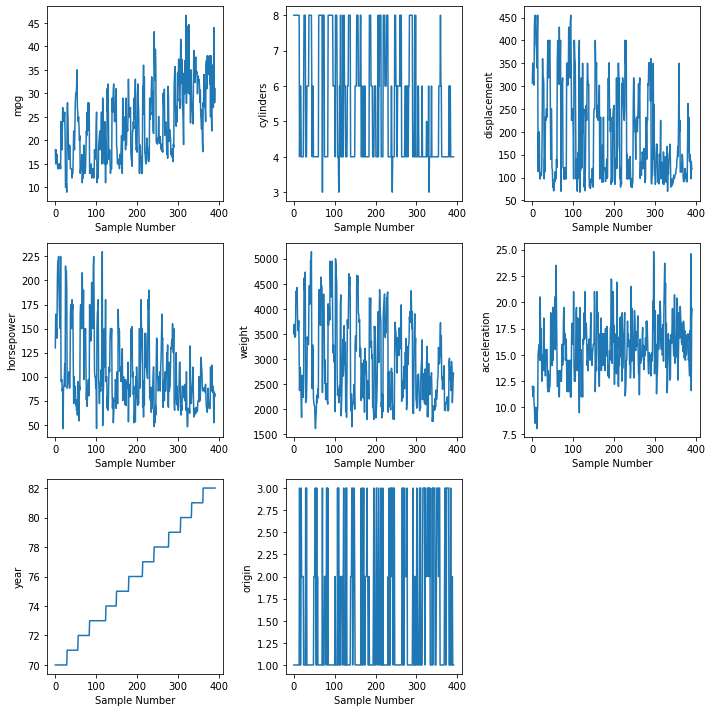

In [182]:
# now let's plot each data column separately
plt.figure(figsize=(10, 10))
nrow, ncol = data.shape
for c in range(ncol):
    plt.subplot(3, 3, c+1)
    plt.plot(data[:, c])
    plt.xlabel('Sample Number')
    plt.ylabel(names[c])
plt.tight_layout()

What is interesting to you in these graphs?

Let's try to predict miles per gallon, *mpg*, from the other attributes.  To set this up, let's make a 392 x 1 column vector, *T*, of target values containing all of the *mpg* values, and a 392 x 7 matrix, *X*, to hold the inputs to our model.

In [183]:
# give me the target values (mpg)
T = data[:, 0:1]  # data[:,0] results in a one-dimensional matrix, data[:,0:1] preserves its two-dimensional nature.
print(data[:,0],"\n",T)

[18.  15.  18.  16.  17.  15.  14.  14.  14.  15.  15.  14.  15.  14.
 24.  22.  18.  21.  27.  26.  25.  24.  25.  26.  21.  10.  10.  11.
  9.  27.  28.  25.  19.  16.  17.  19.  18.  14.  14.  14.  14.  12.
 13.  13.  18.  22.  19.  18.  23.  28.  30.  30.  31.  35.  27.  26.
 24.  25.  23.  20.  21.  13.  14.  15.  14.  17.  11.  13.  12.  13.
 19.  15.  13.  13.  14.  18.  22.  21.  26.  22.  28.  23.  28.  27.
 13.  14.  13.  14.  15.  12.  13.  13.  14.  13.  12.  13.  18.  16.
 18.  18.  23.  26.  11.  12.  13.  12.  18.  20.  21.  22.  18.  19.
 21.  26.  15.  16.  29.  24.  20.  19.  15.  24.  20.  11.  20.  19.
 15.  31.  26.  32.  25.  16.  16.  18.  16.  13.  14.  14.  14.  29.
 26.  26.  31.  32.  28.  24.  26.  24.  26.  31.  19.  18.  15.  15.
 16.  15.  16.  14.  17.  16.  15.  18.  21.  20.  13.  29.  23.  20.
 23.  24.  25.  24.  18.  29.  19.  23.  23.  22.  25.  33.  28.  25.
 25.  26.  27.  17.5 16.  15.5 14.5 22.  22.  24.  22.5 29.  24.5 29.
 33.  20.  18.  18.5

In [184]:
X = data[:, 1:] # give me the input variables
X

array([[  8. , 307. , 130. , ...,  12. ,  70. ,   1. ],
       [  8. , 350. , 165. , ...,  11.5,  70. ,   1. ],
       [  8. , 318. , 150. , ...,  11. ,  70. ,   1. ],
       ...,
       [  4. , 135. ,  84. , ...,  11.6,  82. ,   1. ],
       [  4. , 120. ,  79. , ...,  18.6,  82. ,   1. ],
       [  4. , 119. ,  82. , ...,  19.4,  82. ,   1. ]])

In [185]:
X.shape, T.shape, data[:,0].shape

((392, 7), (392, 1), (392,))

In [186]:
Xnames = names[1:]
Tname = names[0]
Xnames, Tname

(['cylinders',
  'displacement',
  'horsepower',
  'weight',
  'acceleration',
  'year',
  'origin'],
 'mpg')

Now, let's see if a linear model makes some sense by plotting the target values versus each of the input variables.

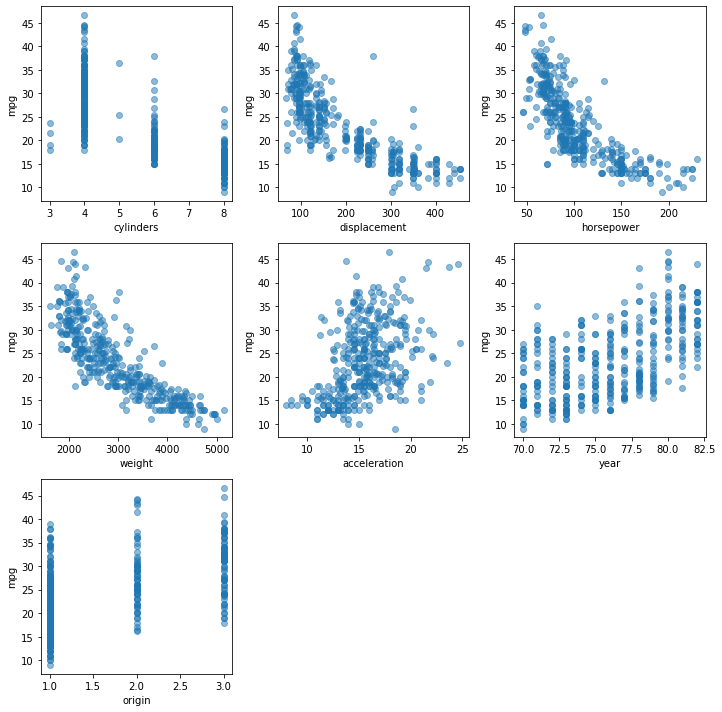

In [187]:
plt.figure(figsize=(10, 10))
for c in range(X.shape[1]):
    plt.subplot(3,3, c+1)
    plt.plot(X[:, c], T, 'o', alpha=0.5)
    plt.ylabel(Tname)
    plt.xlabel(Xnames[c])
plt.tight_layout()

What do you think?  Are there any linear relationships between the individual input variables and the target variable?  Do they make sense, given your knowledge of automobiles?

Now, to build the linear model.  First, let's tack on a column of constant 1 values to the left side of *X*.  With this addition, our matrix multiplication takes care of the $w_0$ coefficient as described above.  We can use ```np.insert``` whose arguments are ```np.insert(array, where, value, axis)```, so to add 1's as a column at index 0, we can do this.

In [188]:
X1 = np.insert(X, 0, 1, 1)
X.shape, X1.shape

((392, 7), (392, 8))

In [189]:
X1[:3, :]

array([[1.000e+00, 8.000e+00, 3.070e+02, 1.300e+02, 3.504e+03, 1.200e+01,
        7.000e+01, 1.000e+00],
       [1.000e+00, 8.000e+00, 3.500e+02, 1.650e+02, 3.693e+03, 1.150e+01,
        7.000e+01, 1.000e+00],
       [1.000e+00, 8.000e+00, 3.180e+02, 1.500e+02, 3.436e+03, 1.100e+01,
        7.000e+01, 1.000e+00]])

And, let's add a name to *Xnames* for the constant 1 column.  The $w_0$ weight is often called the "bias" weight, so let's add the name 'bias'.

In [190]:
Xnames.insert(0, 'bias')
Xnames

['bias',
 'cylinders',
 'displacement',
 'horsepower',
 'weight',
 'acceleration',
 'year',
 'origin']

We could try to fit a linear model to all of the data and check to see
how accurately we predict *mpg* for each sample.  However, this will
give a much too optimistic expectation of how well the model will do
on new data.

A much better way to evaluate a model is to remove, or hold out, some
of the samples from the data set used to fit the model.  Then apply
the model to the held out samples and compare the predicted *mpg*
with the actual *mpg*.  Call these held out samples the **test set**
and the other samples used to fit the model the **train set**.  

How should we partition the data into these two disjoint subsets?  A
common practice is to randomly select 80% of the samples as training
samples and use the remaining 20% of the samples as testing samples.

To partition our samples  (rows of X and T ) into training and test sets, let's deal with just the row indices.  Then we will use the same selected row indices to slice out corresponding rows of X and T.

First let's calculate the number of samples in our training set and testing set.

In [212]:
nrows = X1.shape[0]
nTrain = int(round(nrow * 0.8))
nTest = nrow - nTrain
nTrain, nTest, nTrain + nTest

(314, 78, 392)

Now we want to randomly select 314 samples (rows) as our training set, and the remaining samples (row) as our testing set.  One way to do this is just to randomly permute an array row indices, then select the first 314 for the training set and the remaining 78 as our testing set.

In [213]:
rows = np.arange(nrows)
np.random.shuffle(rows)
rows

array([200, 101, 273, 323,  33,  95, 292, 191, 281, 250, 377, 339,  90,
       272, 303, 217,  44, 228,  12, 104, 379, 162,  67, 120, 229, 381,
       152, 342, 208, 226,   0, 192,   6, 175,  82, 194, 331, 218,  10,
       139,  26, 137, 374, 358,  38, 180, 233, 364, 302, 140, 359,  98,
       249, 102, 375, 225,  14,  39, 230,  74,  23, 244, 258,  76,  78,
       167, 256, 310, 269,  56,  58, 286,  65, 118, 345, 155,   8, 346,
        93, 204, 176, 300, 294,  59, 161,  37, 211,  73,  43, 279,  30,
       351, 110, 103, 125, 284, 145, 213, 307, 245,  52, 355, 220, 232,
        15,  75, 107, 185, 360, 283, 353, 336, 337, 304,  25, 242, 134,
       164, 290,  89, 186,  92,  28, 216,  45, 214, 357, 383, 362,  63,
         3, 255, 203,  85, 247, 117,  22, 240, 169, 219, 262, 166, 378,
       231,  54, 296, 109, 311, 133, 132,  53, 384, 266, 121, 131, 178,
        17,  81, 159, 367, 265, 321, 184, 234, 156, 391,  21,  88, 221,
       143,  50, 113, 197, 340, 127, 274, 315, 324,  69, 263, 28

In [214]:
trainIndices = rows[:nTrain]
testIndices = rows[nTrain:]
trainIndices, testIndices

(array([200, 101, 273, 323,  33,  95, 292, 191, 281, 250, 377, 339,  90,
        272, 303, 217,  44, 228,  12, 104, 379, 162,  67, 120, 229, 381,
        152, 342, 208, 226,   0, 192,   6, 175,  82, 194, 331, 218,  10,
        139,  26, 137, 374, 358,  38, 180, 233, 364, 302, 140, 359,  98,
        249, 102, 375, 225,  14,  39, 230,  74,  23, 244, 258,  76,  78,
        167, 256, 310, 269,  56,  58, 286,  65, 118, 345, 155,   8, 346,
         93, 204, 176, 300, 294,  59, 161,  37, 211,  73,  43, 279,  30,
        351, 110, 103, 125, 284, 145, 213, 307, 245,  52, 355, 220, 232,
         15,  75, 107, 185, 360, 283, 353, 336, 337, 304,  25, 242, 134,
        164, 290,  89, 186,  92,  28, 216,  45, 214, 357, 383, 362,  63,
          3, 255, 203,  85, 247, 117,  22, 240, 169, 219, 262, 166, 378,
        231,  54, 296, 109, 311, 133, 132,  53, 384, 266, 121, 131, 178,
         17,  81, 159, 367, 265, 321, 184, 234, 156, 391,  21,  88, 221,
        143,  50, 113, 197, 340, 127, 274, 315, 324

Check that the training and testing sets are disjoint.

In [215]:
np.intersect1d(trainIndices, testIndices)

array([], dtype=int32)

In [216]:
Xtrain = X1[trainIndices, :]
Ttrain = T[trainIndices, :]
Xtest = X1[testIndices, :]
Ttest = T[testIndices, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((314, 8), (314, 1), (78, 8), (78, 1))

Now we can use the SGD loop previously shown to find good weights.

First let's add a calculation to track the error.  We want to watch how quickly the sum of squared errors, over all samples, is decreasing. More meaningful is the square root of the mean of squared errors (RMSE) so that the units of the error are in the same units of the target variables, rather than the square of them.

RMSE is computed by taking all residuals (if computing over the training data) or *errors* (if computing over the testing data) and computing their quadratic mean, or $\sqrt{\frac{1}{n}(r_1^2 + r_2^2 + ... + r_n^2)}$ where $r \in R$, the set of residuals.

Look at the tiny size of the ```learning_rate```.  Try editing the value and run the following code cell again.

In [217]:
learning_rate = 0.0000001
n_epochs = 50

n_samples, n_inputs = Xtrain.shape  # number of rows in data equals the number of samples

w = np.zeros((n_inputs, 1))                # initialize the weights to zeros

for epoch in range(n_epochs):             # train for this many epochs, or passes through the data set
    sqerror_sum = 0

    for n in range(n_samples):
        y = Xtrain[n:n + 1, :] @ w      # predicted value, y, for sample n
        error = Ttrain[n:n + 1, :] - y  
        # update weights by fraction of negative derivative of square error with respect to weights
        # print(y.shape, error.shape, (X1[n:n+1,:].T * error).shape)
        w += learning_rate * Xtrain[n:n + 1, :].T * error
        sqerror_sum += error ** 2

        rmse = np.sqrt(sqerror_sum / n_samples)
    rmse = rmse[0, 0]  # because rmse is 1x1 matrix
    print(f'Epoch {epoch + 1} RMSE {rmse:.2f}')
        
print(w)

Epoch 1 RMSE 19.34
Epoch 2 RMSE 18.38
Epoch 3 RMSE 17.51
Epoch 4 RMSE 16.76
Epoch 5 RMSE 16.11
Epoch 6 RMSE 15.55
Epoch 7 RMSE 15.07
Epoch 8 RMSE 14.65
Epoch 9 RMSE 14.29
Epoch 10 RMSE 13.98
Epoch 11 RMSE 13.71
Epoch 12 RMSE 13.48
Epoch 13 RMSE 13.28
Epoch 14 RMSE 13.10
Epoch 15 RMSE 12.94
Epoch 16 RMSE 12.80
Epoch 17 RMSE 12.67
Epoch 18 RMSE 12.56
Epoch 19 RMSE 12.45
Epoch 20 RMSE 12.35
Epoch 21 RMSE 12.26
Epoch 22 RMSE 12.18
Epoch 23 RMSE 12.10
Epoch 24 RMSE 12.02
Epoch 25 RMSE 11.94
Epoch 26 RMSE 11.87
Epoch 27 RMSE 11.80
Epoch 28 RMSE 11.74
Epoch 29 RMSE 11.67
Epoch 30 RMSE 11.61
Epoch 31 RMSE 11.54
Epoch 32 RMSE 11.48
Epoch 33 RMSE 11.42
Epoch 34 RMSE 11.36
Epoch 35 RMSE 11.30
Epoch 36 RMSE 11.24
Epoch 37 RMSE 11.18
Epoch 38 RMSE 11.12
Epoch 39 RMSE 11.07
Epoch 40 RMSE 11.01
Epoch 41 RMSE 10.95
Epoch 42 RMSE 10.90
Epoch 43 RMSE 10.84
Epoch 44 RMSE 10.79
Epoch 45 RMSE 10.73
Epoch 46 RMSE 10.68
Epoch 47 RMSE 10.63
Epoch 48 RMSE 10.57
Epoch 49 RMSE 10.52
Epoch 50 RMSE 10.47
[[ 0.0023

Now that we have a linear model, which is simply $w$, let's use it to predict *mpg* for the first four samples.

In [218]:
predict = Xtrain[:4,:] @ w
predict

array([[26.52179996],
       [28.67375849],
       [38.10341549],
       [32.61520091]])

How do these predictions compare with the actual *mpg* values?  We can either make a two column matrix, or use a *for* loop to print them.

In [219]:
np.hstack(( predict, Ttrain[:4, :]))

array([[26.52179996, 17.5       ],
       [28.67375849, 26.        ],
       [38.10341549, 17.        ],
       [32.61520091, 44.3       ]])

Go back to the training loop and try different values of ```learning_rate``` and ```n_epochs```.  Try to find values that result in lowest RMSE.

In [220]:
print('{:^5} {:^5}'.format('P', 'T'))
for (p, t) in zip(predict, Ttrain[0:4, :]):
    print('{:5.2f} {:5.2f}'.format(p[0], t[0]))

  P     T  
26.52 17.50
28.67 26.00
38.10 17.00
32.62 44.30


Let's try all of the test data and plot the results.

In [221]:
predict = Xtest @ w
predict.shape, Ttest.shape

((78, 1), (78, 1))

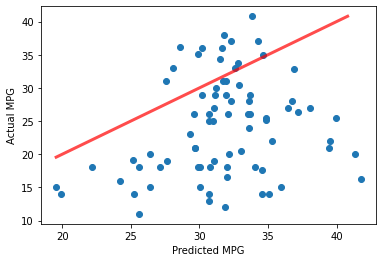

In [222]:
plt.plot(predict, Ttest, 'o')
plt.xlabel('Predicted MPG')
plt.ylabel('Actual MPG')
# add a 45 degree line
a = max(min(predict), min(Ttest))
b = min(max(predict), max(Ttest))
plt.plot([a, b], [a ,b], 'r', linewidth=3, alpha=0.7);

(choose one)[Not too shabby!, Not great!]  But, how about a numerical measure of accuracy?  

Right, just calculate the root-mean-square error (RMSE).

In [223]:
rmse = np.sqrt( np.mean( (Xtest @ w - Ttest)**2))
print("Our predictions are about %.4s mpg off, on average." % rmse)

Our predictions are about 10.7 mpg off, on average.


## Standarizing Variables

From trying different values of ```learning_rate``` you should have discovered that its value must be very small to prevent the incremental updates to $w$ from resulting in NaN.  This is because a larger ```learning_rate``` when multiplied by inputs $x$ that are large results in too large a change in $w$ and sends you farther up the opposite side of the bowl that is the quadratic error function we are trying to minimize.

Is there a general way to deal with this problem?

Recall that our variables have widely different ranges, as seen in the plots.  Let's make a table of the ranges.

In [224]:
mins = np.min(X1, axis=0)
maxs = np.max(X1, axis=0)
for vi in range(X1.shape[1]):
    print(f"{Xnames[vi]:12} {mins[vi]:7.1f}, {maxs[vi]:7.1f}")
    

bias             1.0,     1.0
cylinders        3.0,     8.0
displacement    68.0,   455.0
horsepower      46.0,   230.0
weight        1613.0,  5140.0
acceleration     8.0,    24.8
year            70.0,    82.0
origin           1.0,     3.0


Since each input value is multiplied by its own weight, the magnitude of the weights are very dependent on the range of its input values.  This also means the step size in the gradient descent is very dependent on the range of input values.

To minimize this effect, lets **standardize** our variables.  To do this we will adjust the values of each input variable so that it has a mean of zero and a standard deviation of 1 over all training samples (recall, standard deviation ($\sigma$ denotes the amount of dispersion in a set of values---the value(s) most dispersed from the mean should have the highest standard deviation of the set).

Of course we do this before tacking on the column of constant 1s, or, equivalently, if the 1s are already there only adjust all columns except the first one.

To do this correctly when partitioning data into training and testing sets, we must always calculate means and standard deviations using only the training set, and use the same means and standard deviations when standardizing the testing set.  Remember, you must not use any information about the testing set when building a model.  If you do, your test error will be lower than it will be when you truly see new data.

You can do this by storing the means and standard deviations obtained from the training data, and just use them when standardizing the testing data.  Don't forget that we don't standardize the column of constant 1s.

In [225]:
Xmeans = np.mean(Xtrain[:, 1:], axis=0)
Xstds = np.std(Xtrain[:, 1:], axis=0)
Xmeans, Xstds

(array([5.52866242e+00, 1.97906051e+02, 1.05748408e+02, 3.00627707e+03,
        1.55585987e+01, 7.59713376e+01, 1.56687898e+00]),
 array([1.72305650e+00, 1.05166814e+02, 3.86039470e+01, 8.53211794e+02,
        2.79000821e+00, 3.62876953e+00, 8.04239446e-01]))

In [226]:
Xtrain[:, 1:] = (Xtrain[:, 1:] - Xmeans) / Xstds
np.mean(Xtrain, axis=0), np.std(Xtrain, axis=0)

(array([ 1.00000000e+00,  1.04657967e-16,  7.74327524e-17, -1.14558045e-16,
        -1.06072263e-17,  5.89611516e-15, -1.08759428e-15, -1.26933142e-16]),
 array([0., 1., 1., 1., 1., 1., 1., 1.]))

In [227]:
Xmeans.shape

(7,)

In [228]:
Xtest[:, 1:] = (Xtest[:, 1:] - Xmeans) / Xstds

In [229]:
learning_rate = 0.001
n_epochs = 50

n_samples, n_inputs = Xtrain.shape  # number of rows in data equals the number of samples

w = np.zeros((n_inputs, 1))                # initialize the weights to zeros

for epoch in range(n_epochs):             # train for this many epochs, or passes through the data set
    sqerror_sum = 0

    for n in range(n_samples):
        y = Xtrain[n:n + 1, :] @ w      # predicted value, y, for sample n
        error = Ttrain[n:n + 1, :] - y  
        # update weights by fraction of negative derivative of square error with respect to weights
        # print(y.shape, error.shape, (X1[n:n+1,:].T * error).shape)
        w += learning_rate * Xtrain[n:n + 1, :].T * error
        sqerror_sum += error ** 2

    rmse = np.sqrt(sqerror_sum / n_samples)
    rmse = rmse[0, 0]  # because rmse is 1x1 matrix
    print(f'Epoch {epoch + 1} RMSE {rmse:.2f}')
        
print(w)

Epoch 1 RMSE 20.86
Epoch 2 RMSE 15.22
Epoch 3 RMSE 11.39
Epoch 4 RMSE 8.68
Epoch 5 RMSE 6.80
Epoch 6 RMSE 5.54
Epoch 7 RMSE 4.73
Epoch 8 RMSE 4.23
Epoch 9 RMSE 3.94
Epoch 10 RMSE 3.77
Epoch 11 RMSE 3.67
Epoch 12 RMSE 3.61
Epoch 13 RMSE 3.58
Epoch 14 RMSE 3.56
Epoch 15 RMSE 3.55
Epoch 16 RMSE 3.54
Epoch 17 RMSE 3.53
Epoch 18 RMSE 3.52
Epoch 19 RMSE 3.52
Epoch 20 RMSE 3.51
Epoch 21 RMSE 3.51
Epoch 22 RMSE 3.51
Epoch 23 RMSE 3.50
Epoch 24 RMSE 3.50
Epoch 25 RMSE 3.50
Epoch 26 RMSE 3.49
Epoch 27 RMSE 3.49
Epoch 28 RMSE 3.49
Epoch 29 RMSE 3.48
Epoch 30 RMSE 3.48
Epoch 31 RMSE 3.48
Epoch 32 RMSE 3.48
Epoch 33 RMSE 3.47
Epoch 34 RMSE 3.47
Epoch 35 RMSE 3.47
Epoch 36 RMSE 3.47
Epoch 37 RMSE 3.47
Epoch 38 RMSE 3.46
Epoch 39 RMSE 3.46
Epoch 40 RMSE 3.46
Epoch 41 RMSE 3.46
Epoch 42 RMSE 3.46
Epoch 43 RMSE 3.46
Epoch 44 RMSE 3.45
Epoch 45 RMSE 3.45
Epoch 46 RMSE 3.45
Epoch 47 RMSE 3.45
Epoch 48 RMSE 3.45
Epoch 49 RMSE 3.45
Epoch 50 RMSE 3.45
[[ 2.32768040e+01]
 [-3.47712422e-01]
 [ 2.38547553e-01]

In [230]:
predict = Xtest @ w
predict.shape, Ttest.shape

((78, 1), (78, 1))

In [231]:
print('{:^5} {:^5}'.format('P', 'T'))
for (p, t) in zip(predict, Ttest[0:4, :]):
    # print(p,t)
    print('{:5.2f} {:5.2f}'.format(p[0], t[0]))

  P     T  
30.02 29.00
12.29 13.00
13.77 16.50
26.09 28.00


Let's try all of the test data and plot the results.

In [232]:
predict = Xtest @ w
predict.shape, Ttest.shape

((78, 1), (78, 1))

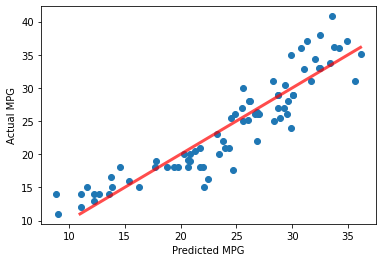

In [233]:
plt.plot(predict, Ttest, 'o')
plt.xlabel('Predicted MPG')
plt.ylabel('Actual MPG')
# add a 45 degree line
a = max(min(predict), min(Ttest))
b = min(max(predict), max(Ttest))
plt.plot([a, b], [a ,b], 'r', linewidth=3, alpha=0.7);

That's better.  With standardized variables, results are less sensitive to different values of ```learning_rate```.

## Importance of Attributes (Input Variables)

Here again are the weights we learned before for predicting *mpg*.
Can we use these to decide which attibutes are most important for predicting *mpg*?  Can
we remove some from the model?


A weight
magnitude is determined not only by the linear relationship between the corresponding input variable with
the target, but also by the variable's range.  If we had not standardized the variables, then variables with very small range could result in large magnitude weights, while variables with a large range would result in small magnitude weights.  In that case the magnitudes of the weights cannot be used to judge relative importance of variables.  However, standardized variables does allow us to compare weight magnitudes to choose important variables.

Let's see what the ranges of our standardized variables are.

In [234]:
mins = np.min(Xtrain, axis=0)
maxs = np.max(Xtrain, axis=0)
for vi in range(Xtrain.shape[1]):
    print(f"{Xnames[vi]:12} {mins[vi]:7.1f}, {maxs[vi]:7.1f}")

bias             1.0,     1.0
cylinders       -1.5,     1.4
displacement    -1.2,     2.4
horsepower      -1.5,     3.2
weight          -1.6,     2.5
acceleration    -2.7,     3.3
year            -1.6,     1.7
origin          -0.7,     1.8


In [240]:
w

array([[ 2.32768040e+01],
       [-3.47712422e-01],
       [ 2.38547553e-01],
       [-1.14817422e+00],
       [-4.00369282e+00],
       [-2.04504373e-02],
       [ 2.66932473e+00],
       [ 1.05982541e+00]])

In [241]:
for wi, name in zip(w.flat, Xnames):
    print('{:8.3f}  {:s}'.format(wi, name))

  23.277  bias
  -0.348  cylinders
   0.239  displacement
  -1.148  horsepower
  -4.004  weight
  -0.020  acceleration
   2.669  year
   1.060  origin


Now what do you observe about the relative magnitudes?  If you had a ton of input variables, it would be easier to see if we sorted them by their magnitudes.

In [242]:
np.abs(w)

array([[2.32768040e+01],
       [3.47712422e-01],
       [2.38547553e-01],
       [1.14817422e+00],
       [4.00369282e+00],
       [2.04504373e-02],
       [2.66932473e+00],
       [1.05982541e+00]])

In [245]:
np.argsort(np.abs(w.flat))

array([5, 2, 1, 7, 3, 6, 4, 0], dtype=int64)

In [246]:
np.argsort(np.abs(w.flat))[::-1]  # one way to reverse the order

array([0, 4, 6, 3, 7, 1, 2, 5], dtype=int64)

In [248]:
sortedOrder = np.argsort(np.abs(w.flat))[::-1]
Xnames = np.array(Xnames)
for wi, name in zip(w.flat[sortedOrder], Xnames[sortedOrder]):
    print(f'{wi:8.3f}  {name:s}')

  23.277  bias
  -4.004  weight
   2.669  year
  -1.148  horsepower
   1.060  origin
  -0.348  cylinders
   0.239  displacement
  -0.020  acceleration


Does this order correspond to what you would expect for predicting *mpg*?  Positive weights indicate that the corresponding variable is positively correlated to *mpg*, while negative ones indicate a negative correlation.

Which variables might you try removing from the input variables to see if the results are better?

## Multiple Target Components

The beauty of matrix equations now shines.   Previously $T$ was an $N
\times 1$ matrix of target 
values, one per sample.  

Just add additional columns of target values for each
target component.  So $T$ becomes an $N \times K$ matrix,
if there are $K$ output components.  Each row is one
$K$-dimensional sample.  

Let's use this to predict miles per gallon **and** horsepower.

First, let's assemble the data for predicting MPG and HP.

In [249]:
X = data[:, [1, 2, 4, 5, 6, 7]]
T = data[:, [0, 3]]

Tnames = [names[0], names[3]]
Xnames = np.array(names)[[1, 2, 4, 5, 6, 7]]

print(X.shape)
print(Xnames)
print(T.shape)
print(Tnames)

(392, 6)
['cylinders' 'displacement' 'weight' 'acceleration' 'year' 'origin']
(392, 2)
['mpg', 'horsepower']


In [250]:
Xtrain = X[trainIndices, :]
Ttrain = T[trainIndices, :]
Xtest = X[testIndices, :]
Ttest = T[testIndices, :]
Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape

((314, 6), (314, 2), (78, 6), (78, 2))

In [251]:
Xmeans = Xtrain.mean(axis=0)
Xstds = Xtrain.std(axis=0)
Xtrain = (Xtrain - Xmeans) / Xstds
Xtest = (Xtest - Xmeans) / Xstds

Xtrain = np.insert(Xtrain, 0, 1, 1)
Xtest = np.insert(Xtest, 0, 1, 1)

Xnames = np.insert(Xnames, 0, 'bias', 0)
Xnames

array(['bias', 'cylinders', 'displacement', 'weight', 'acceleration',
       'year', 'origin'], dtype='<U12')

In [253]:
Xtrain.shape, Ttrain.shape

((314, 7), (314, 2))

Now we can train our linear model to predict both *mpg* and *horsepower*.

In [264]:
learning_rate = 0.0001    # notice the much higher learning rate!
n_epochs = 50

n_samples, n_inputs = Xtrain.shape  # number of rows in data equals the number of samples

w = np.zeros((n_inputs, 2))               # initialize the weights to zeros. NOTICE HOW HAS 2 COLUMNS

for epoch in range(n_epochs):             # train for this many epochs, or passes through the data set
    sqerror_sum = 0

    for n in range(n_samples):
        y = Xtrain[n:n + 1, :] @ w      # predicted value, y, for sample n
        error = Ttrain[n:n + 1, :] - y  
        # update weights by fraction of negative derivative of square error with respect to weights
        # print(y.shape, error.shape, (X1[n:n+1,:].T * error).shape)
        w += learning_rate * Xtrain[n:n + 1, :].T * error
        sqerror_sum += error ** 2

    rmse = np.sqrt(sqerror_sum / n_samples)
    rmse = rmse[0, 0]  # because rmse is 1x1 matrix
    print(f'Epoch {epoch + 1} RMSE {rmse:.2f}')
        
print(w)

Epoch 1 RMSE 24.13
Epoch 2 RMSE 23.28
Epoch 3 RMSE 22.47
Epoch 4 RMSE 21.71
Epoch 5 RMSE 20.99
Epoch 6 RMSE 20.30
Epoch 7 RMSE 19.65
Epoch 8 RMSE 19.03
Epoch 9 RMSE 18.43
Epoch 10 RMSE 17.86
Epoch 11 RMSE 17.31
Epoch 12 RMSE 16.79
Epoch 13 RMSE 16.28
Epoch 14 RMSE 15.79
Epoch 15 RMSE 15.32
Epoch 16 RMSE 14.87
Epoch 17 RMSE 14.43
Epoch 18 RMSE 14.01
Epoch 19 RMSE 13.61
Epoch 20 RMSE 13.21
Epoch 21 RMSE 12.84
Epoch 22 RMSE 12.47
Epoch 23 RMSE 12.12
Epoch 24 RMSE 11.78
Epoch 25 RMSE 11.45
Epoch 26 RMSE 11.13
Epoch 27 RMSE 10.82
Epoch 28 RMSE 10.53
Epoch 29 RMSE 10.24
Epoch 30 RMSE 9.96
Epoch 31 RMSE 9.70
Epoch 32 RMSE 9.44
Epoch 33 RMSE 9.19
Epoch 34 RMSE 8.96
Epoch 35 RMSE 8.72
Epoch 36 RMSE 8.50
Epoch 37 RMSE 8.29
Epoch 38 RMSE 8.08
Epoch 39 RMSE 7.88
Epoch 40 RMSE 7.69
Epoch 41 RMSE 7.51
Epoch 42 RMSE 7.33
Epoch 43 RMSE 7.16
Epoch 44 RMSE 7.00
Epoch 45 RMSE 6.84
Epoch 46 RMSE 6.69
Epoch 47 RMSE 6.54
Epoch 48 RMSE 6.40
Epoch 49 RMSE 6.27
Epoch 50 RMSE 6.14
[[ 18.4334677   83.76916261]
 

In [265]:
Xnames = np.array(Xnames)
for targeti in range(2):
    print('\n Weights for {} target\n'.format(Tnames[targeti]))
    thisw = w[:, targeti]
    sortedOrder = np.argsort(np.abs(thisw))[::-1]
    for wi ,name in zip(thisw[sortedOrder], Xnames[sortedOrder]):
        print(f'{wi:8.3f}  {name:s}')


 Weights for mpg target

  18.433  bias
   2.170  year
  -2.157  weight
  -1.472  displacement
  -1.352  cylinders
   1.007  origin
   0.453  acceleration

 Weights for horsepower target

  83.769  bias
  10.284  weight
 -10.237  acceleration
   9.756  displacement
   7.716  cylinders
  -4.316  year
  -0.383  origin


Now let's use our single model to predict both mpg and horsepower.

In [266]:
prediction = Xtest @ w
prediction.shape

(78, 2)

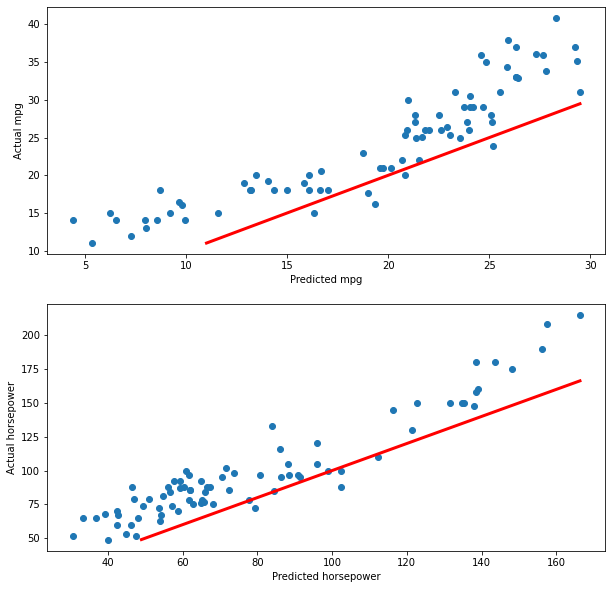

In [267]:
plt.figure(figsize=(10,10))
for p in range(2):
    plt.subplot(2, 1, p + 1)
    plt.plot(prediction[:, p], Ttest[:, p], 'o')
    plt.xlabel("Predicted " + Tnames[p])
    plt.ylabel("Actual " + Tnames[p])
    a = max(min(prediction[:, p]), min(Ttest[:, p]))
    b = min(max(prediction[:, p]), max(Ttest[:, p]))
    plt.plot([a, b], [a, b], 'r', linewidth=3)

How well did we do in terms of RMSE?

In [268]:
rmseTrain = np.sqrt(np.mean((Xtrain @ w - Ttrain)**2, axis=0))
rmseTrain

array([ 6.07746067, 25.87120362])

In [269]:
rmseTest = np.sqrt(np.mean((Xtest @ w - Ttest)**2, axis=0))
rmseTest

array([ 5.74959221, 23.73844936])

In [270]:
print('Training RMSE: MPG {:4.2f} HP {:4.2f}'.format(*rmseTrain))   #what is that * doing there??
print('Testing RMSE: MPG {:4.2f} HP {:4.2f}'.format(*rmseTest))

Training RMSE: MPG 6.08 HP 25.87
Testing RMSE: MPG 5.75 HP 23.74


What is that * doing there?

In [274]:
def foo(x,y,z):
    print("x: ",x)
    print("y: ",y)
    print("z: ",z)

In [275]:
lst = [1,2,3]
foo(lst)

TypeError: foo() missing 2 required positional arguments: 'y' and 'z'

In [276]:
foo(*lst)

x:  1
y:  2
z:  3


Anyway, looks like we have a bigger error for HP.  But maybe this is due to large range of HP.

In [277]:
Ttest.min(0), Ttest.max(0) # print min and max of each target in testing data

(array([11., 49.]), array([ 40.8, 215. ]))

In [280]:
print("MPG goes from %4s-%4s, HP goes from %4s-%4s" % (Ttest.min(0)[0],Ttest.max(0)[0],Ttest.min(0)[1],Ttest.max(0)[1]))

MPG goes from 11.0-40.8, HP goes from 49.0-215.0
